In [1]:
import os
from urllib.request import urlopen

In [2]:
import cdsapi
import xarray as xr

In [3]:
import pandas as pd

pd.options.display.float_format = "{:20,.2f}".format

In [3]:
c = cdsapi.Client(
    key=os.getenv("CDS_API_KEY"),
    url="https://cds.climate.copernicus.eu/api",
)

2025-02-03 11:43:55,279 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 11:43:55,280 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


In [4]:
r = c.retrieve(
    "reanalysis-era5-single-levels",
    {
        "variable": "2t",  # 2-meter temperature
        "product_type": "reanalysis",
        "date": "1982-07-22",
        "time": [f"{str(i).zfill(2)}:00" for i in range(0, 24)],  # Get all 24 hours
        "format": "netcdf",
    },
)
with urlopen(r.location) as f, open("./data/era5-t2m.netcdf", "wb") as b:
    b.write(f.read())

2025-02-03 11:43:55,825 INFO Request ID is 2a38c472-c7e4-4831-8f45-300615b44a0f
2025-02-03 11:43:55,980 INFO status has been updated to accepted
2025-02-03 11:44:04,782 INFO status has been updated to successful


In [4]:
ds = xr.open_dataset("./data/era5-t2m.netcdf")

In [5]:
ds

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 24, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 192B 1982-07-22 ... 1982-07-22T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 384B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 100MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-03T16:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
df = ds.to_dataframe()

In [8]:
df.head()

number expver                  t2m
valid_time latitude longitude                                    
1982-07-22 90.00    0.00            0   0001               274.17
                    0.25            0   0001               274.17
                    0.50            0   0001               274.17
                    0.75            0   0001               274.17
                    1.00            0   0001               274.17

In [9]:
df = df.reset_index()

In [10]:
df.head()

,valid_time,latitude,longitude,number,expver,t2m
0,1982-07-22,90.00,0.00,0,0001,274.17
1,1982-07-22,90.00,0.25,0,0001,274.17
2,1982-07-22,90.00,0.50,0,0001,274.17
3,1982-07-22,90.00,0.75,0,0001,274.17
4,1982-07-22,90.00,1.00,0,0001,274.17


<Axes: >

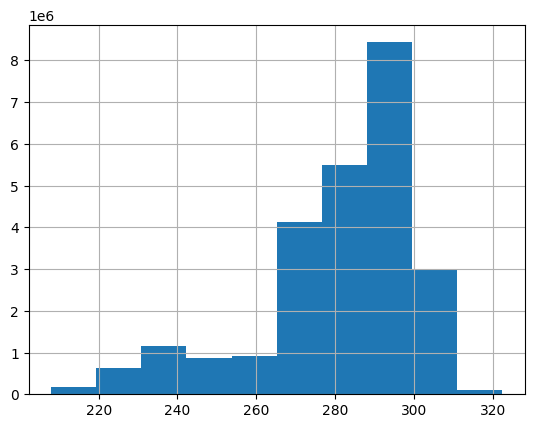

In [11]:
df.t2m.hist()

In [12]:
df["t2m"] = df["t2m"] - 273.15

<Axes: >

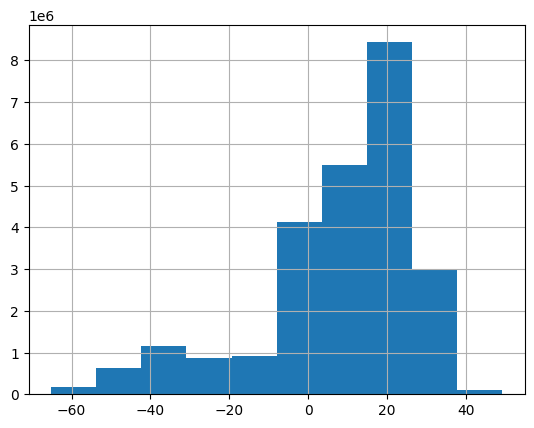

In [14]:
df.t2m.hist()

In [15]:
df.valid_time.value_counts().reset_index()

,valid_time,count
0,1982-07-22 00:00:00,1038240
1,1982-07-22 01:00:00,1038240
2,1982-07-22 02:00:00,1038240
3,1982-07-22 03:00:00,1038240
4,1982-07-22 04:00:00,1038240
5,1982-07-22 05:00:00,1038240
6,1982-07-22 06:00:00,1038240
7,1982-07-22 07:00:00,1038240
8,1982-07-22 08:00:00,1038240
9,1982-07-22 09:00:00,1038240


In [16]:
daily_ranges = (
    df.groupby(["longitude", "latitude"])
    .agg({"t2m": ["min", "mean", "max", "count"]})
    .reset_index()
)

In [17]:
daily_ranges.head()

longitude             latitude                  t2m  \
                                                             min   
0                 0.00               -90.00               -39.20   
1                 0.00               -89.75               -39.02   
2                 0.00               -89.50               -39.15   
3                 0.00               -89.25               -38.89   
4                 0.00               -89.00               -39.14   

                                                   
                  mean                  max count  
0               -37.74               -36.77    24  
1               -37.47               -36.60    24  
2               -37.35               -36.31    24  
3               -37.01               -35.79    24  
4               -36.87               -35.54    24

In [18]:
daily_ranges.columns = [
    "longitude",
    "latitude",
    "t2m_min",
    "t2m_mean",
    "t2m_max",
    "n",
]

In [19]:
daily_ranges.head()

,longitude,latitude,t2m_min,t2m_mean,t2m_max,n
0,0.00,-90.00,-39.20,-37.74,-36.77,24
1,0.00,-89.75,-39.02,-37.47,-36.60,24
2,0.00,-89.50,-39.15,-37.35,-36.31,24
3,0.00,-89.25,-38.89,-37.01,-35.79,24
4,0.00,-89.00,-39.14,-36.87,-35.54,24


In [20]:
daily_ranges.tail()

,longitude,latitude,t2m_min,t2m_mean,t2m_max,n
1038235,359.75,89.00,0.36,0.63,0.96,24
1038236,359.75,89.25,0.37,0.60,0.94,24
1038237,359.75,89.50,0.38,0.58,0.89,24
1038238,359.75,89.75,0.38,0.59,0.88,24
1038239,359.75,90.00,0.43,0.72,1.02,24


In [21]:
df.longitude.describe()

count          24,917,760.00
mean                  179.88
std                   103.92
min                     0.00
25%                    89.94
50%                   179.88
75%                   269.81
max                   359.75
Name: longitude, dtype: float64

In [22]:
def convert_longitude_to_180_scale(x: float | int) -> float | int:
    """Convert longitude values that run on 0-360 scale to a -180-180 scale.

    Based on instructions published by the ECWMF at https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515

    Args:
        x (float | int): A longitude value on a scale that runs from 0-360.

    Returns:
        The value converted to a -180-180 scale.

    Examples:
        >>> convert_longitude_to_180_scale(0)
        0
        >>> convert_longitude_to_180_scale(180)
        180
        >>> convert_longitude_to_180_scale(181)
        -179
        >> convert_longitude_to_180_scale(360)
        0
    """
    return x - 360 if x > 180 else x

In [23]:
daily_ranges["longitude"] = daily_ranges.longitude.apply(convert_longitude_to_180_scale)

In [24]:
assert (daily_ranges.n == 24).all()